# ⚡ Energy Consumption Forecasting

This project forecasts short-term household energy usage using time series data. We explore multiple modeling approaches:
- Prophet (seasonality-aware)
- ARIMA (traditional statistical model)
- XGBoost (machine learning)

We use the **Household Power Consumption Dataset**, clean and resample it, engineer time-based features, and compare forecasting results.


In [69]:
# Import pandas for data handling
import pandas as pd

# Import matplotlib and seaborn for charts
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
#importing prophet
from prophet import Prophet
# ignore warnings to keep notebook clean
import warnings

## 🔍 Step 1: Load and Inspect the Dataset

We begin by reading the dataset, parsing datetime values, and cleaning the data for use in forecasting.


In [70]:
# Load the CSV file (use your downloaded filename) as I have used mine
df = pd.read_csv(
    "Electricity_consumption.csv",
    low_memory=False,
    na_values=['?', 'NA', 'null']  # Convert bad data to NaN
)


## 🛠️ Step 2: Preprocessing and Resampling

We convert all features to numeric types and resample the data to daily average energy usage.


In [71]:
# Reset index in case datetime was already used before
df = df.reset_index()

# Check available columns
print(df.columns)  # Ensure 'Date' and 'Time' or 'datetime' is present

# If you see separate Date and Time columns, combine them:
if 'Date' in df.columns and 'Time' in df.columns:
    df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], errors='coerce', dayfirst=True)
    df.drop(columns=['Date', 'Time'], inplace=True)
elif 'datetime' in df.columns:
    df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
else:
    raise ValueError("Missing datetime columns!")

# Set datetime as index
df.set_index('datetime', inplace=True)
df.sort_index(inplace=True)


Index(['index', 'Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')


In [72]:
# Convert all columns to numeric, forcing errors to NaN, This is done so that the data in  strings can be converted into numeric values except date and time
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')


## 🧠 Step 3: Feature Engineering

We create time-based features like day of week, month, and weekend indicator to help certain models learn time-based patterns.


In [73]:
# Resample to daily mean
daily_df = df.resample('D').mean().reset_index()


In [74]:
# Create time-related features
daily_df['year'] = daily_df['datetime'].dt.year
daily_df['month'] = daily_df['datetime'].dt.month
daily_df['day'] = daily_df['datetime'].dt.day
daily_df['weekday'] = daily_df['datetime'].dt.dayofweek
daily_df['is_weekend'] = daily_df['weekday'].isin([5, 6]).astype(int)


## 🔮 Step 4: Prophet Forecasting

Prophet is a seasonality-aware model that automatically detects trends, holidays, and weekly patterns. We train Prophet and visualize forecasts.


In [75]:
# Lets Build Forecasting Models and start with Prophet, which is beginner-friendly and great for capturing seasonality, trends, and holidays.
# Select target feature and rename as required by Prophet
prophet_df = daily_df[['datetime', 'Global_active_power']].copy()
prophet_df.rename(columns={'datetime': 'ds', 'Global_active_power': 'y'}, inplace=True)

# Drop missing rows
prophet_df.dropna(inplace=True)


In [76]:
from prophet import Prophet

# Prepare data
prophet_df = daily_df[['datetime', 'Global_active_power']].copy()
prophet_df.rename(columns={'datetime': 'ds', 'Global_active_power': 'y'}, inplace=True)

# Drop NaN rows
prophet_df.dropna(inplace=True)

# Check format
prophet_df.head()


,ds,y
0,2006-12-16,3.053475
1,2006-12-17,2.354486
2,2006-12-18,1.530435
3,2006-12-19,1.157079
4,2006-12-20,1.545658


In [77]:
# Create and train the model
model = Prophet()
model.fit(prophet_df)


13:13:44 - cmdstanpy - INFO - Chain [1] start processing
13:13:44 - cmdstanpy - INFO - Chain [1] done processing


In [78]:
# Create future dates and forecast into the future
future = model.make_future_dataframe(periods=30)  # 30 days ahead

# Predict future values
forecast = model.predict(future)

# View forecast
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
1458,2010-12-22,1.487778,1.089225,1.838750
1459,2010-12-23,1.394829,0.992996,1.777822
1460,2010-12-24,1.455325,1.077561,1.822431
1461,2010-12-25,1.657184,1.309572,2.005692
1462,2010-12-26,1.632408,1.248324,2.014418


## 📈 Prophet Results

We visualize both the forecasted values and the learned seasonal components like weekly or yearly trends.


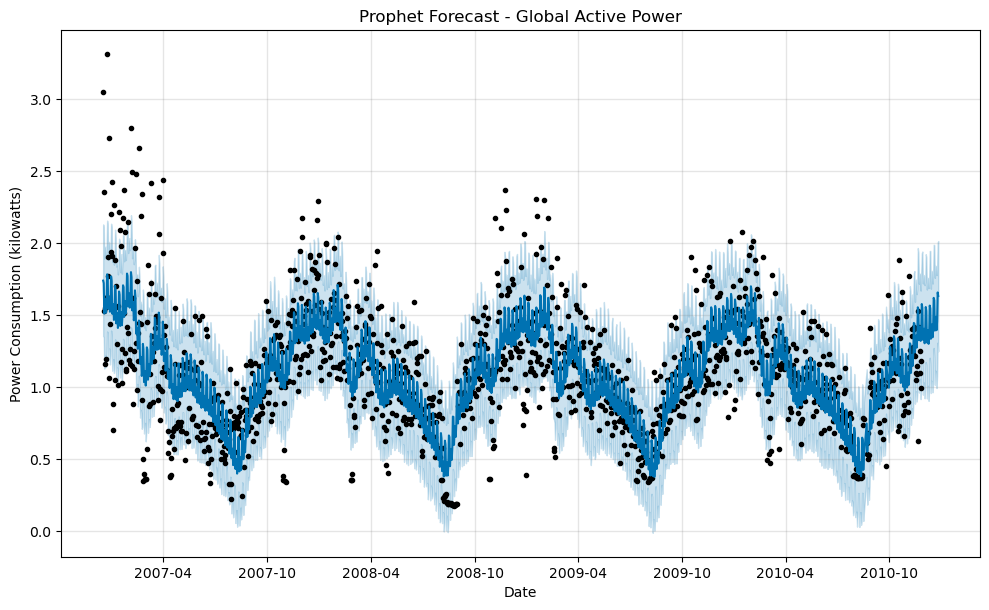

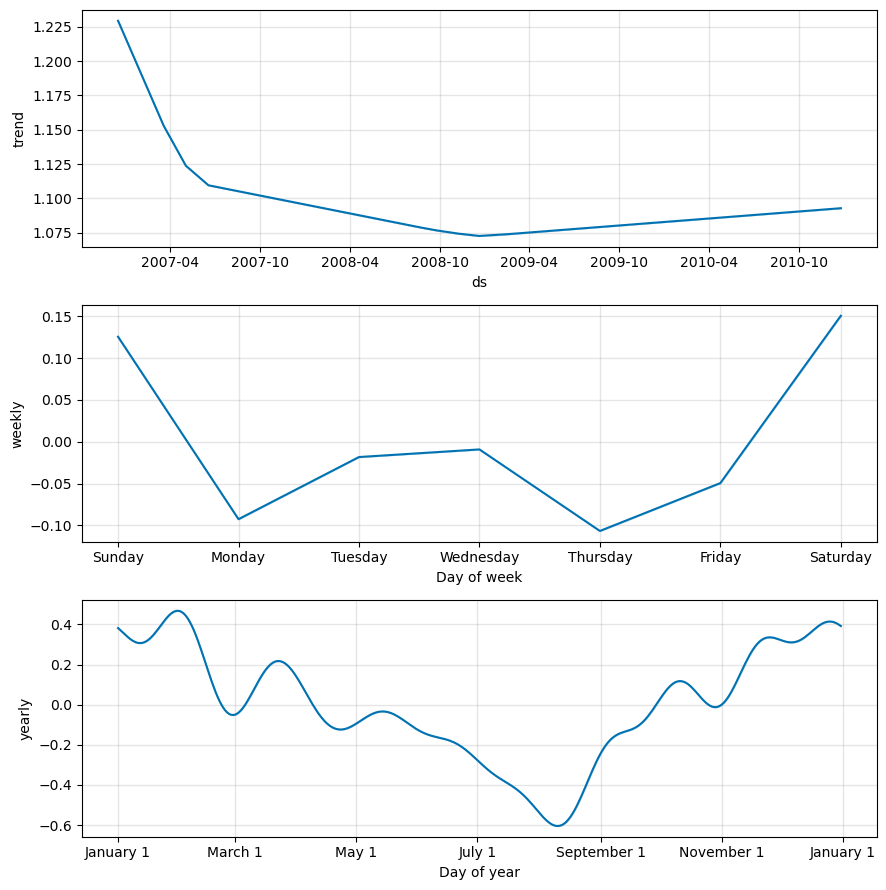

In [79]:
# Plot predictions
model.plot(forecast)
plt.title("Prophet Forecast - Global Active Power")
plt.xlabel("Date")
plt.ylabel("Power Consumption (kilowatts)")
plt.show()

# Plot components (trend + seasonality)
model.plot_components(forecast)
plt.show()


In [80]:
!pip install statsmodels


## 📉 Step 5: ARIMA Forecasting

ARIMA is a statistical model suited for time series with autocorrelation. We use a simple (5,1,2) configuration and forecast 30 days into the future.


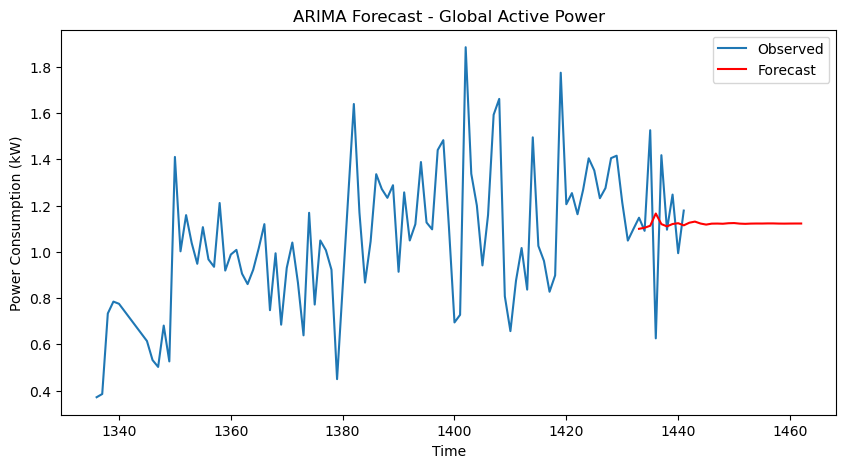

In [81]:
# Lets build Build ARIMA Model on Global_active_power and We'll use daily_df['Global_active_power'].

from statsmodels.tsa.arima.model import ARIMA
import numpy as np

# Drop NaNs for modeling
series = daily_df['Global_active_power'].dropna()

# Fit ARIMA model (can adjust order)
model_arima = ARIMA(series, order=(5,1,2))  # (p,d,q)
arima_result = model_arima.fit()

# Forecast 30 days
arima_forecast = arima_result.forecast(steps=30)

# Plot
plt.figure(figsize=(10,5))
plt.plot(series[-100:], label="Observed")
plt.plot(np.arange(len(series), len(series) + 30), arima_forecast, label="Forecast", color='red')
plt.title("ARIMA Forecast - Global Active Power")
plt.xlabel("Time")
plt.ylabel("Power Consumption (kW)")
plt.legend()
plt.show()
## Ignore the warnings as Arima is telling us that they dont use a datetime index, They'll just use numbers like 0, 1, 2, … for forecasting.


In [82]:
#Now lets go for XGBoost Forecasting model. We can compare them/ Models for our own reference. 

!pip install xgboost



## 🤖 Step 6: XGBoost Forecasting & 📊 XGBoost Results


We use XGBoost, a powerful machine learning model, to forecast energy consumption based on lag features. The model is evaluated using RMSE.

We compare predicted vs actual values visually and print the RMSE to measure forecasting accuracy.


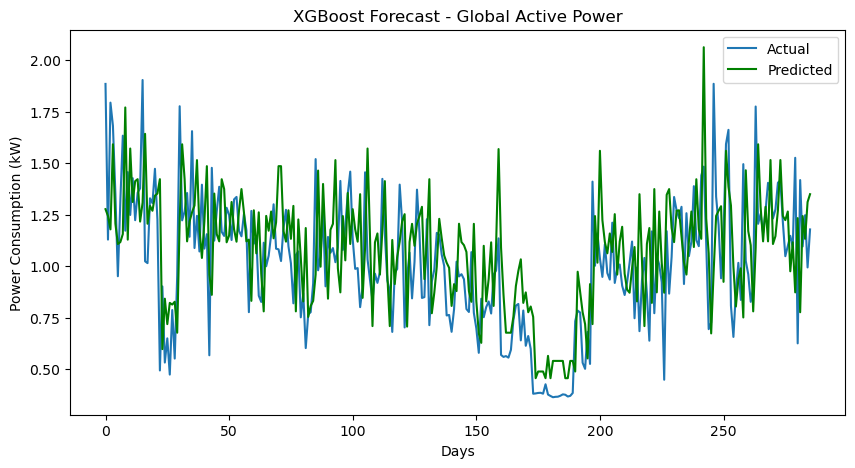

RMSE (XGBoost): 0.288


In [83]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Create lag features
df_xgb = daily_df[['datetime', 'Global_active_power']].copy()
df_xgb['lag1'] = df_xgb['Global_active_power'].shift(1)
df_xgb.dropna(inplace=True)

# Features and target
X = df_xgb[['lag1']]
y = df_xgb['Global_active_power']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Train model
model_xgb = xgb.XGBRegressor(n_estimators=100)
model_xgb.fit(X_train, y_train)

# Predict
y_pred = model_xgb.predict(X_test)

# Plot
plt.figure(figsize=(10,5))
plt.plot(y_test.values, label="Actual")
plt.plot(y_pred, label="Predicted", color='green')
plt.title("XGBoost Forecast - Global Active Power")
plt.xlabel("Days")
plt.ylabel("Power Consumption (kW)")
plt.legend()
plt.show()

# Error
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE (XGBoost): {rmse:.3f}")


## ✅ Conclusion

We successfully compared multiple forecasting models:
- **Prophet** captures seasonality and trends visually well.
- **ARIMA** gives fast forecasts with decent accuracy but less interpretability.
- **XGBoost** performs well numerically using lag-based learning.

Each method has strengths, and model choice should depend on use-case goals like accuracy, interpretability, or trend analysis.
